In [43]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer


In [44]:
df = pd.read_csv(r"C:\Users\2T Computer\Downloads\Máy học\predictive_maintenance_dirty_dataset.csv")

In [45]:
df.head()

,Timestamp,Machine_ID,Temperature,Vibration,Pressure,Rotation_Speed,Failure
0,2025-08-01 00:33:00,PUMP_003,47.2 C,~2.26,314.738608,1534.211253,0
1,2025-08-01 01:08:00,PUMP_003,57.896064077536955,2.3837173645764542,NaN,NaN,0
2,2025-08-01 02:04:00,pump-001,51.20981135783017,1.043359877671101,292.750822,1485.942812,False
3,2025-08-01 03:02:00,PUMP_004,45.45987962239394,1.2938481493323541,324.656488,1494.355592,0
4,2025-08-01 03:25:00,PUMP_003,49.87772411252967,2.1777756585612162,314.170111,1520.811546,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       305 non-null    object 
 1   Machine_ID      305 non-null    object 
 2   Temperature     276 non-null    object 
 3   Vibration       275 non-null    object 
 4   Pressure        275 non-null    float64
 5   Rotation_Speed  275 non-null    float64
 6   Failure         305 non-null    object 
dtypes: float64(2), object(5)
memory usage: 16.8+ KB


In [47]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

In [48]:
df["Machine_ID"].unique()


array(['PUMP_003', 'pump-001', 'PUMP_004', 'Pump_002'], dtype=object)

In [49]:
# Chuyển hết về chữ hoa
df["Machine_ID"] = df["Machine_ID"].str.upper()
# Thay thế dấu '-' thành '_'
df["Machine_ID"] = df["Machine_ID"].str.replace("-", "_", regex=False)

In [50]:
df["Machine_ID"].unique()

array(['PUMP_003', 'PUMP_001', 'PUMP_004', 'PUMP_002'], dtype=object)

In [51]:
# Loại bỏ ký tự "C", "~" và khoảng trắng
df["Temperature"] = df["Temperature"].astype(str).str.replace("C", "", regex=False).str.strip()
df["Vibration"] = df["Vibration"].astype(str).str.replace("~", "", regex=False).str.strip()
# Chuyển sang kiểu float
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")
df["Vibration"] = pd.to_numeric(df["Vibration"], errors="coerce")

In [52]:
df["Pressure"].describe()

count    275.000000
mean     287.944695
std      117.920940
min     -332.909426
25%      304.206094
50%      310.870352
75%      316.576708
max      336.997141
Name: Pressure, dtype: float64

In [53]:
# Gán giá trị âm thành null để xử lí
df.loc[df["Pressure"] < 0, "Pressure"] = None

In [54]:
df.duplicated().sum()

5

In [55]:
df = df.drop_duplicates()

In [56]:
df.isnull().sum()

Timestamp          0
Machine_ID         0
Temperature       28
Vibration         30
Pressure          40
Rotation_Speed    30
Failure            0
dtype: int64

In [57]:
# Thay NaN trong tất cả các cột số liệu bằng median
num_cols = ["Temperature", "Vibration", "Pressure", "Rotation_Speed"]

for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

df.isnull().sum()

Timestamp         0
Machine_ID        0
Temperature       0
Vibration         0
Pressure          0
Rotation_Speed    0
Failure           0
dtype: int64

In [58]:
df["Failure"].unique()

array(['0', 'False', 'Error', 'True', '1'], dtype=object)

In [66]:
# Loại bỏ các dòng có giá trị "error" trong cột Failure
df = df[df["Failure"].astype(str).str.lower().str.strip() != "error"]

# Chuẩn hóa Failure về 0/1
df["Failure"] = df["Failure"].astype(str).str.lower().str.strip()
df["Failure"] = df["Failure"].replace({"1": 1, "true": 1, "0": 0, "false": 0})

# Ép kiểu int
df["Failure"] = df["Failure"].astype(int)

C:\Users\2T Computer\AppData\Local\Temp\ipykernel_1704\4236670014.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Failure"] = df["Failure"].replace({"1": 1, "true": 1, "0": 0, "false": 0})


C:\Users\2T Computer\AppData\Local\Temp\ipykernel_1704\251252701.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="Set2")


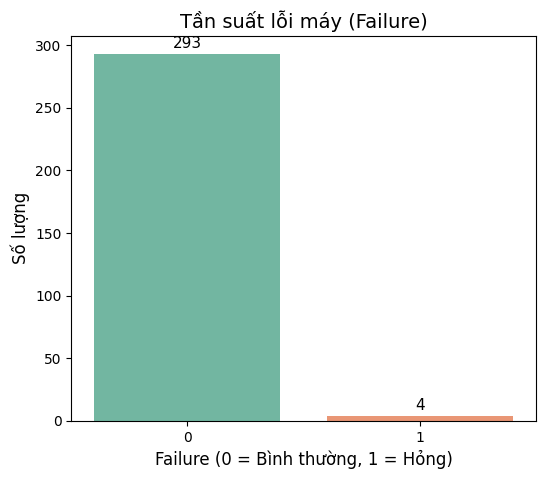

In [65]:
# Đếm tần suất
failure_counts = df["Failure"].value_counts().sort_index()

# Vẽ biểu đồ cột
plt.figure(figsize=(6,5))
sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="Set2")

# Thêm nhãn
plt.title("Tần suất lỗi máy (Failure)", fontsize=14)
plt.xlabel("Failure (0 = Bình thường, 1 = Hỏng)", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)

# Hiển thị giá trị trên cột
for i, v in enumerate(failure_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=11)

plt.show()

In [60]:
cols = ["Temperature","Vibration", "Pressure", "Rotation_Speed"]

for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} giá trị ngoại lai")

Temperature: 24 giá trị ngoại lai
Vibration: 23 giá trị ngoại lai
Pressure: 18 giá trị ngoại lai
Rotation_Speed: 16 giá trị ngoại lai


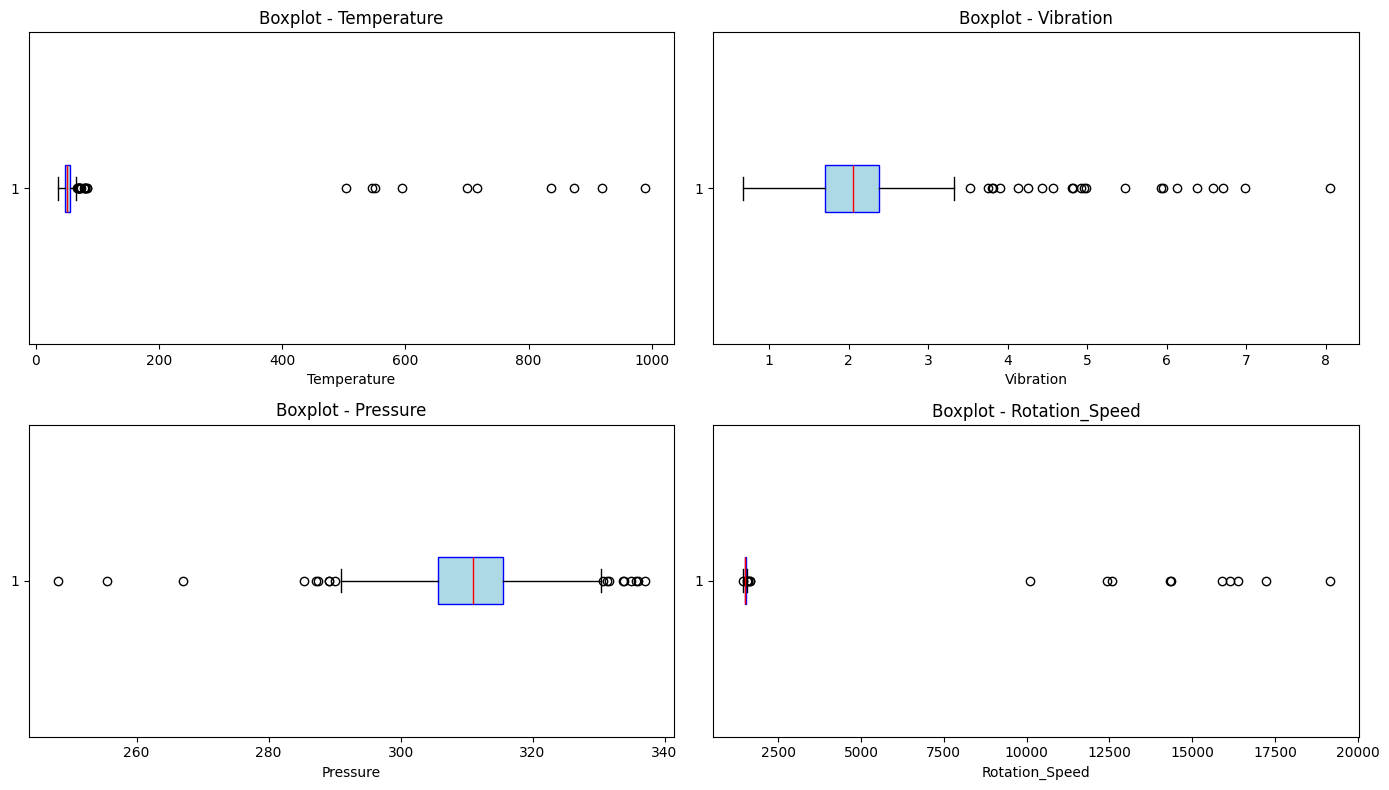

In [61]:
import matplotlib.pyplot as plt

cols = ["Temperature", "Vibration", "Pressure", "Rotation_Speed"]

plt.figure(figsize=(14, 8))

# Vẽ boxplot cho từng cột
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(df[col], vert=False, patch_artist=True,
                boxprops=dict(facecolor="lightblue", color="blue"),
                medianprops=dict(color="red"))
    plt.title(f"Boxplot - {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [62]:
for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)


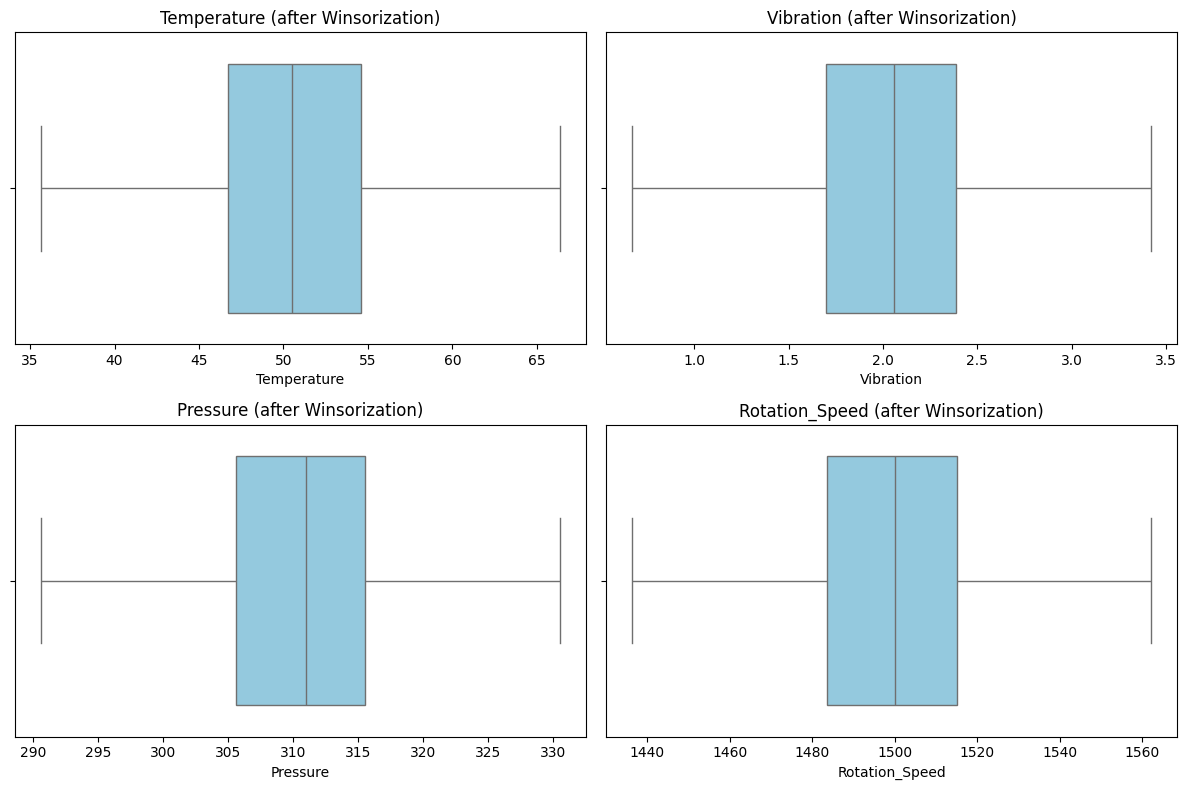

In [64]:
plt.figure(figsize=(12,8))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"{col} (after Winsorization)")

plt.tight_layout()
plt.show()

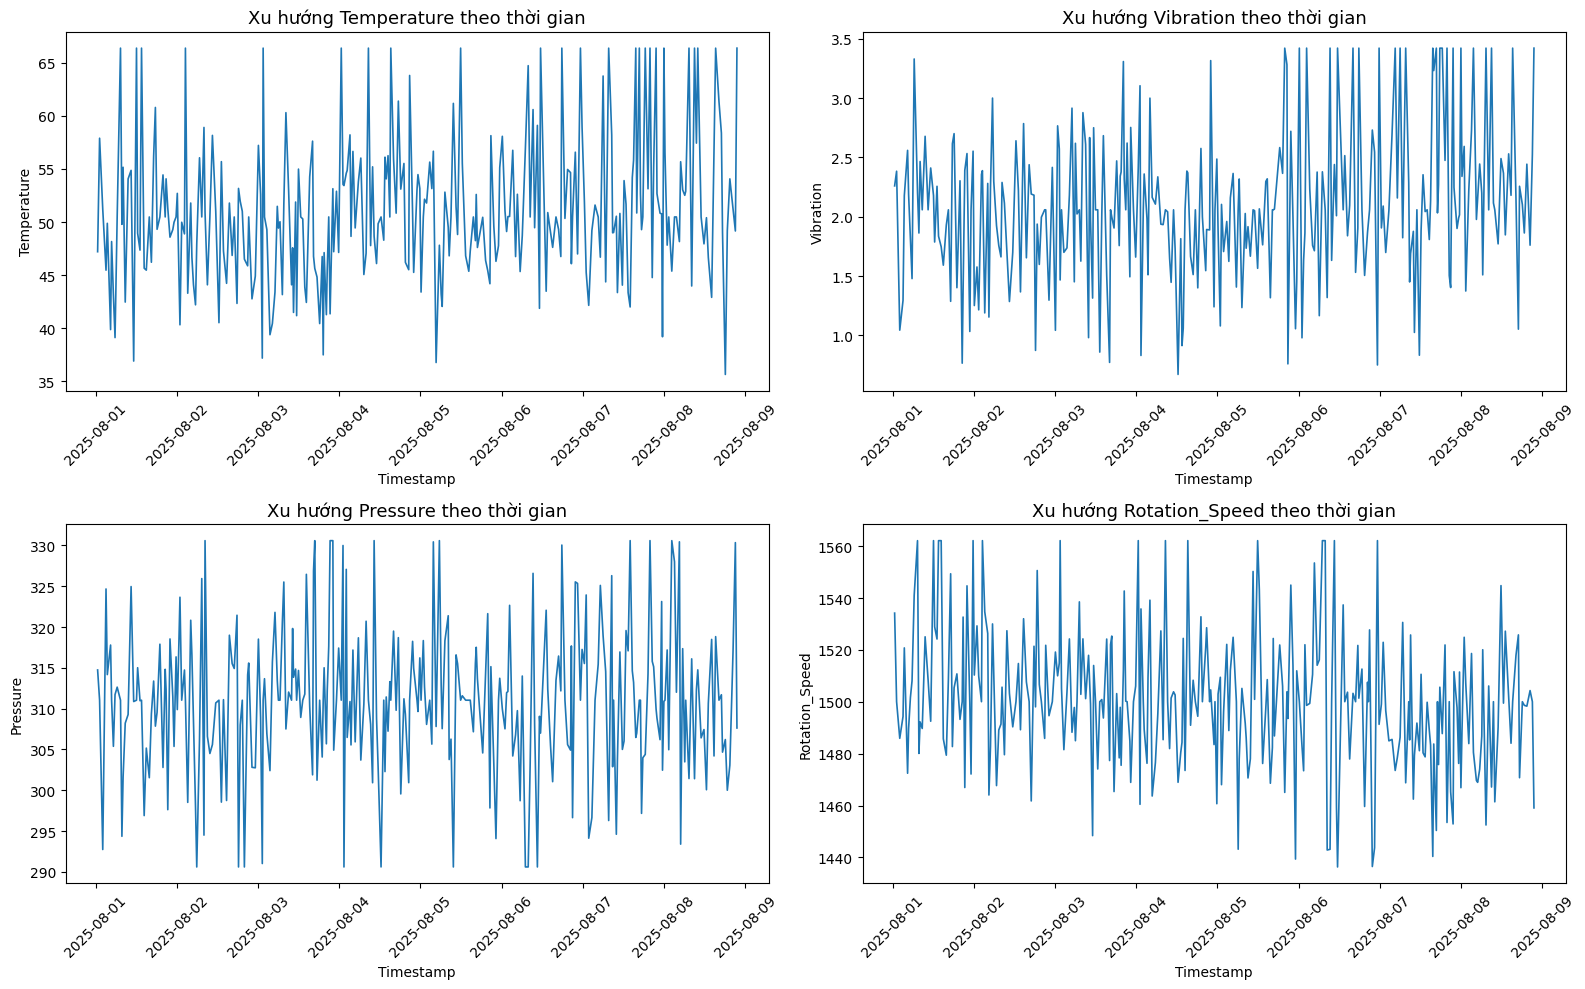

In [69]:
plt.figure(figsize=(16, 10))

features = ["Temperature", "Vibration", "Pressure", "Rotation_Speed"]

for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=df, x="Timestamp", y=col, linewidth=1.2)
    plt.title(f"Xu hướng {col} theo thời gian", fontsize=13)
    plt.xlabel("Timestamp")
    plt.ylabel(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()